# Example 01 - Modulations Dataset
This notebook steps through an example of how to use `torchsig` to instantiate a `SignalDataset` containing 53 unique modulations. The notebook then plots the signals using `Visualizers` for both the IQ and Spectrogram representations of the dataset. The end of the notebook then shows how the instantiated dataset can be saved to an LMDB static dataset for standalone research, experimentation, and/or analysis.

----
### Import Libraries
First, import all the necessary public libraries as well as a few classes from the `torchsig` toolkit.

In [1]:
import lmdb
import pickle
import numpy as np
from tqdm import tqdm
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Subset

from torchsig.datasets import ModulationsDataset
from torchsig.utils.dataset import SignalDataset
import torchsig.transforms as ST
from torchsig.utils.visualize import IQVisualizer, SpectrogramVisualizer
from sklearn.model_selection import train_test_split


/home/silvija/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/silvija/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/silvija/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
MOD_BATCH_SIZE = 64
RANDOM_SEED = 42
NUM_DATA_LOADER_WORKERS = 4


----
### Instantiate Modulations Dataset
Next, instantiate the `ModulationsDataset` by passing in the desired classes, a boolean specifying whether to use the class name or index as the label, the desired level of signal impairments/augmentations, the number of IQ samples per example, and the total number of samples. Note that the total number of samples will be divided evenly among the class list (for example, `num_samples=5300` will result in 100x samples of each of the 53 modulation classes). Also note that the classes input parameter can be omitted if all classes are desired. 

If all classes are included at `level=0` (clean signals), all signals will occupy roughly half of the returned signal bandwidth except for the FSK and MSK modulations. These two subfamilies do not contain any pulse shaping, and as such are returned at roughly 1/8th occupied bandwidth for the main lobe. At the higher impairment levels, there is a randomized low pass filter applied at the 8x oversampled rate to suppress the sidelobes prior to downsampling to roughly the same half bandwidth target as the remaining signals.

Within the OFDM family, there are 12 subclasses pertaining to the number of subcarriers present within the OFDM signal. These subcarriers are the powers of 2 from 64 to 2048 as well as the LTE specifications values of 72, 180, 300, 600, 900, and 1200. The DC subcarrier is randomly on or off throughout all subcarrier counts. The subcarrier modulations are divided into two categories: 1) randomly select a single modulation from the list: `bpsk, qpsk, 16qam, 64qam, 256qam, and 1024qam` and modulate all subcarriers with the random selection; and 2) randomly select a modulation from the same list for each subcarrier independently. The subcarrier modulations are not included in any of the labels for future classification tasks. In addition to these randomizations, the cyclic prefix ratio is also randomly selected between discrete values of 1/8 and 1/4, and it is also not included in the labels at this time. As a final randomization with the OFDM signals, two distinct sidelobe suppression techniques are evenly sampled from to smooth the discontinuities at the symbol boundaries: 1) apply a window, and 2) apply a low pass filter.

In [3]:
'''
classes = [
    "ook","bpsk","4pam","4ask","qpsk","8pam","8ask","8psk","16qam","16pam",
    "16ask","16psk","32qam","32qam_cross","32pam","32ask","32psk","64qam","64pam","64ask",
    "64psk","128qam_cross","256qam","512qam_cross","1024qam","2fsk","2gfsk","2msk","2gmsk","4fsk",
    "4gfsk","4msk","4gmsk","8fsk","8gfsk","8msk","8gmsk","16fsk","16gfsk","16msk","16gmsk",
    "ofdm-64","ofdm-72","ofdm-128","ofdm-180","ofdm-256","ofdm-300","ofdm-512","ofdm-600",
    "ofdm-900","ofdm-1024","ofdm-1200","ofdm-2048",
]
'''
classes = [
    "bpsk","8pam","8psk","16qam","16pam",
    "64qam","64psk","256qam","1024qam","16gmsk",
]
num_classes = len(classes)
level = 0
include_snr = False #True

fft_size = 32
num_iq_samples = fft_size * fft_size
num_samples = 20

post_transform = ST.Compose([
    ST.Spectrogram(nperseg=fft_size, noverlap=0, nfft=fft_size, mode='psd'),
    ST.Normalize(norm=np.inf, flatten=True),
])
data_transform = ST.Compose([
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
'''   Reshaping does not work
    ST.Lambda(lambda x: SignalData(\
                data=x.iq_data.reshape((x.iq_data.shape[0], int(round(np.sqrt(x.iq_data.shape[1]))), int(round(np.sqrt(x.iq_data.shape[1])))))),\
                item_type=np.dtype(np.float64),\
                data_type=np.dtype(np.float64),\
                signal_description=x.signal_description,\
            )
])
'''

# Seed the dataset instantiation for reproduceability
pl.seed_everything(1234567891)

dataset = ModulationsDataset(
    classes=classes,
    use_class_idx=True, #False,
    level=level,
    num_iq_samples=1024,
    num_samples=int(num_classes*100),
    include_snr=include_snr,
    transform = data_transform
)

idx = 600
if include_snr:
    data, (modulation, snr) = dataset[idx]
else:
    data, modulation = dataset[idx]
print("Dataset length: {}".format(len(dataset)))
print("Number of classes: {}".format(num_classes))
print("Data shape: {}".format(data.shape))
print("Example modulation: {}".format(modulation))
if include_snr:
    print("SNR: {}".format(snr))

Global seed set to 1234567891


Dataset length: 1000
Number of classes: 10
Data shape: (2, 1024)
Example modulation: 6


In [4]:
def _make_train_valid_split(ds_train, len_ds_test):
    train_loader = DataLoader(ds_train, batch_size=len(ds_train), shuffle=True)

# Turn dataloader into iterator
    data, labels = next(iter(train_loader))

# Convert image to numpy
    data_np = data.to('cpu').numpy()
    labels_np = labels.to('cpu').numpy()


    train_idxs, valid_idxs, _, _ = train_test_split(
            range(len(ds_train)),
            labels_np,
            stratify=labels_np,
            test_size= len_ds_test / len(ds_train),
            random_state=RANDOM_SEED
        )
    ds_train = Subset(ds_train, train_idxs)
    ds_valid = Subset(ds_train, valid_idxs)

    return ds_train, ds_valid

def _make_data_loaders(ds_train, ds_test):

    dl_train = DataLoader(ds_train, batch_size=MOD_BATCH_SIZE, shuffle=True, num_workers=NUM_DATA_LOADER_WORKERS)
    dl_test = DataLoader(ds_test, batch_size=MOD_BATCH_SIZE, shuffle=False, num_workers=NUM_DATA_LOADER_WORKERS)
    dl_valid = None

    return dl_train, dl_valid, dl_test



In [5]:
def load_sig(classes, level = 0, include_snr = False, dim_size = 32, samples_per_class = 100, validate=False):
    num_classes = len(classes)
    num_iq_samples = dim_size * dim_size

    data_transform = ST.Compose([
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
    ])


# Seed the dataset instantiation for reproduceability
    pl.seed_everything(1234567891)

    ds_train = ModulationsDataset(
    classes=classes,
    use_class_idx=True, #False,
    level=level,
    num_iq_samples=num_iq_samples,
    num_samples=int(num_classes*samples_per_class),
    include_snr=include_snr,
    transform = data_transform
    )
    ds_test_len = int(num_classes*samples_per_class/3)
    ds_train, ds_test = _make_train_valid_split(ds_train, ds_test_len)
    dl_train, dl_valid, dl_test =_make_data_loaders(ds_train, ds_test)
    return dl_train, dl_valid, dl_test, ds_train, ds_test




In [6]:
dl_train, _, dl_test, ds_train, ds_test  = load_sig(classes)

Global seed set to 1234567891


In [7]:
ds_train[0][0].shape

(2, 1024)

In [8]:
ds_train[0][1]

8

In [9]:
ds_train[0][0].dtype

dtype('float64')

In [10]:
output_file = open('modfile.txt', 'ab')
pf = open('modmeta.pkl', 'wb')
mylist = []
offset = 0
for x, y in dl_train:
        #x = x.to(device)
        x = x.detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        xs=x.size * x.itemsize
        mylist.append((y, offset, xs))
        offset = offset+xs
        x.tofile(output_file)


In [11]:
output_file.tell()

32784384

In [12]:
output_file.close()
pickle.dump(mylist, pf)

----
### Plot Subset to Verify
The `IQVisualizer` and the `SpectrogramVisualizer` can be passed a `Dataloader` and plot visualizations of the dataset. The `batch_size` of the `DataLoader` determines how many examples to plot for each iteration over the visualizer. Note that the dataset itself can be indexed and plotted sequentially using any familiar python plotting tools as an alternative plotting method to using the `torchsig` `Visualizer` as shown below.

(1024,)

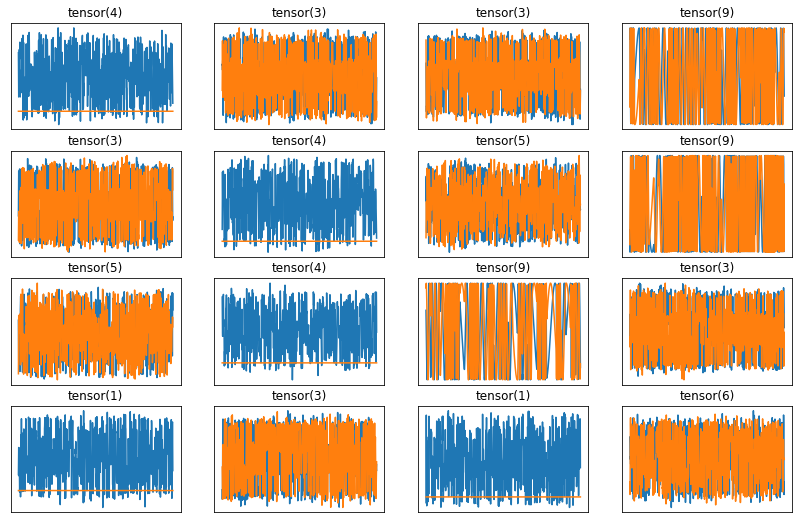

In [4]:
if include_snr:
    # For plotting, omit the SNR values
    class DataWrapper(SignalDataset):
        def __init__(self, dataset):
            self.dataset = dataset
            super().__init__(dataset)
        def __getitem__(self,idx):
            x,(y,z) = self.dataset[idx]
            return x,y
        def __len__(self) -> int:
            return len(self.dataset)
    plot_dataset = DataWrapper(dataset)
else:
    plot_dataset = dataset

data_loader = DataLoader(
    dataset=plot_dataset,
    batch_size=16,
    shuffle=True
)

visualizer = IQVisualizer(
    data_loader=data_loader,
    visualize_transform=None,
)

for figure in iter(visualizer):
    figure.set_size_inches(14, 9)
    plt.show()
    break

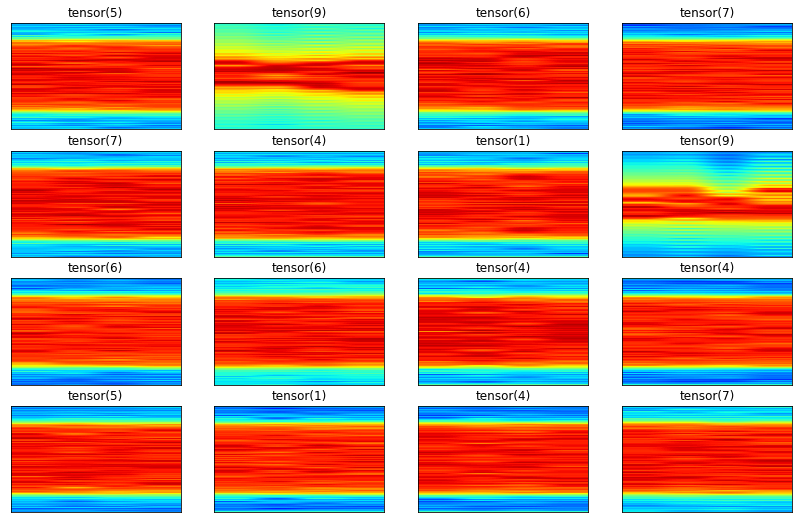

In [5]:
visualizer = SpectrogramVisualizer(
    data_loader=data_loader,
    nfft=1024,
    visualize_transform=None,
)

for figure in iter(visualizer):
    figure.set_size_inches(14, 9)
    plt.show()
    break

----
### Save Data to LMDB
As a final exercise for this example notebook, the dataset can be saved to an LMDB static dataset for offline use. Note this is similar to how the static Sig53 dataset is generated and saved to serve as a static performance evaluation dataset.

In [6]:
env = lmdb.open("dataset", max_dbs=3 if include_snr else 2, map_size=int(1e12))

iq_sample_db = env.open_db('iq_samples'.encode())
modulations_db = env.open_db('modulations'.encode())
if include_snr:
    snrs_db = env.open_db('snrs'.encode())

In [8]:
class_dict = dict(zip(classes,range(len(classes))))

for i in tqdm(range(len(dataset))):
    # Retrieve sample
    if include_snr:
        data, (modulation, snr) = dataset[i]
    else:
        data, modulation = dataset[i]

    # Convert data from complex128 to complex64
    data_c64 = data.astype(np.complex64)
    
    # Save IQ data to database
    with env.begin(write=True,db=iq_sample_db) as txn:
        txn.put(str(i).encode(), pickle.dumps(data_c64))
    # Save modulation to database as class index
    with env.begin(write=True,db=modulations_db) as txn:
        txn.put(str(i).encode(), str(class_dict[modulation]).encode())
    if include_snr:
        # Save SNRs to database
        with env.begin(write=True,db=snrs_db) as txn:
            txn.put(str(i).encode(), str(snr).encode())

  0%|                                                                                                              | 0/5300 [00:00<?, ?it/s]


KeyError: 0